<a href="https://colab.research.google.com/github/junyi2022/musa-650-remote-sensing/blob/main/assignments/HW2/HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MUSA 650 Homework 2: Supervised Land Use Classification with Google Earth Engine

In this assignment, you will use Google Earth Engine via Python to implement multi-class land cover classification. You will hand-label Landsat 8 satellite images which you will then use to train a random forest model. Along the way, you will consider practical remote sensing issues like cloud cover, class imbalances, and feature selection.

Submit a single Jupyter Notebook containing code, narrative text, visualizations, and answers to each question. Please also upload your classification results as a GeoTIFF and your accuracy assessment as a CSV file.

**Disclaimer:** I consulted the following AI tool to revise codes and answer questions for this project.

- DeepSeek. (n.d.). DeepSeek artificial intelligence system. Retrieved from https://www.deepseek.com

**Note:** the output interactive geemap cannot be visualized on GitHub because the 'state' key is missing from 'metadata.widgets'. Although the notebook is 'invalid' on github, we can use it in Colab.

## 1. Setup

`geemap` has many [tutorials](https://geemap.org/tutorials/#geemap-tutorials) available. This notebook specificlly referenced the [#32 Machine Learning with Earth Engine - Supervised Classification](https://geemap.org/notebooks/32_supervised_classification/) and the video is available [here](https://www.youtube.com/watch?v=qWaEfgWi21o)

In [82]:
# Import required libraries
import ee
import geemap
import ipywidgets as widgets
from IPython.display import display
import leafmap

import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import geopandas as gpd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Show all columns
pd.set_option('display.max_columns', None)

In [55]:
class4_palette = ['#DF6149', '#FEDC7B', '#9bcae8', '#6bbf99']

Google Earth Engine requires authentication before usage. Instruction can be found [here](https://developers.google.com/earth-engine/guides/auth). The project is a google cloud project set up in the google cloud account. There is also a notebook autheticator [here](https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/cloud-platform%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=jHMQOVzUM-B-pUwoeKSCPjAqmuPK90lbh-Z2xFjR55o&tc=n8BD6km8I2vhYIau8ww5Hrztwrd5Wulp0qdijy5YqII&cc=Yusop5Cp9Vxq3z_wUl9rzbY_q2YP5o1JUMM4lyLIvJs).

In [6]:
ee.Authenticate()
ee.Initialize(project='ee-musa-remote-sensing')

Create an interactive map. There are multriple base map available.  

In [7]:
Map = geemap.Map()

## 2. Data Collection and Feature Engineering

### 2.1 Collecting and Labeling Training Data

#### 2.1.1 Collecting Data

The region of interest (ROI) of this notebook is Chicago. We have defined a rectangle area of Chicago that will be the area of focus. We first start from adding data to the map. The data used is the Collection 2 for Landsat data in 2023. We filter for images with minimal cloud cover.  

The band info is showed in the form below:

**Landsat 8 (OLI & TIRS) Band Designations**

| Band    | Name                          | Wavelength (µm) | Spatial Resolution (m) | Common Applications |
|---------|-------------------------------|-----------------|------------------------|---------------------|
| **SR_B1** | Coastal/Aerosol               | 0.433–0.453     | 30                     | Coastal water mapping, aerosol studies |
| **SR_B2** | Blue                          | 0.450–0.515     | 30                     | Water body penetration, soil/vegetation discrimination |
| **SR_B3** | Green                         | 0.525–0.600     | 30                     | Healthy vegetation detection, urban areas |
| **SR_B4** | Red                           | 0.630–0.680     | 30                     | Chlorophyll absorption (vegetation health) |
| **SR_B5** | Near-Infrared (NIR)           | 0.845–0.885     | 30                     | Biomass content, water body delineation |
| **SR_B6** | Shortwave Infrared 1 (SWIR 1) | 1.560–1.660     | 30                     | Moisture content, snow/cloud discrimination |
| **SR_B7** | Shortwave Infrared 2 (SWIR 2) | 2.100–2.300     | 30                     | Soil/rock differentiation, vegetation stress |

**Thermal Bands (TIRS)**

| Band     | Name                          | Wavelength (µm) | Spatial Resolution (m) | Common Applications |
|----------|-------------------------------|-----------------|------------------------|---------------------|
| **ST_B10** | Thermal Infrared 1 (TIRS 1)   | 10.60–11.19    | 100 (resampled to 30)  | Surface temperature, urban heat islands |
| **ST_B11** | Thermal Infrared 2 (TIRS 2)   | 11.50–12.51    | 100 (resampled to 30)  | Surface temperature, volcanic activity |

First define the region of interest of Chicago.

In [8]:
chicago_region = ee.Geometry.Rectangle([-88.25, 41.39, -87.8, 41.81])

Then get the landsat image.

In [9]:
# Chicago point
point = ee.Geometry.Point([-87.7719, 41.8799])

# Define scaling function for Landsat Collection 2
def scale_landsat(image):
    # Apply the proper scaling factors for Collection 2
    optical_bands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    return optical_bands.set('system:time_start', image.get('system:time_start'))

image = (
    ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
    .filterBounds(point)
    .filterDate("2023-01-01", "2023-12-31")
    .sort("CLOUD_COVER")
    .first()
    .select("SR_B[1-7]")
    .clip(chicago_region)
)

# Apply scaling to surface reflectance bands
image = scale_landsat(image)

# print(image.getInfo())

Check image properties.

In [10]:
ee.Date(image.get("system:time_start")).format("YYYY-MM-dd").getInfo()

'2023-08-31'

#### 2.1.2 Labeling Data

There are multiple ways to label the data. This notebook use national landcover database (nlcd) layer as a base to generate training points. The values of the points will be reclassified into **0 for urban, 1 for agriculture, 2 for water, and 3 for vegetation**. These 4 categories will be used for the remote sensing model.

First, we want to get the original nlcd data, but it has way more categories than we need.

In [11]:
nlcd = ee.Image("USGS/NLCD/NLCD2016").select("landcover").clip(chicago_region)

In [12]:
print(nlcd.get("landcover_class_values").getInfo())

[11, 12, 21, 22, 23, 24, 31, 41, 42, 43, 51, 52, 71, 72, 73, 74, 81, 82, 90, 95]


In this way, we are going to reclassify nlcd data into the 4 categories that we proposed. **0 for urban, 1 for agriculture, 2 for water, and 3 for vegetation**.

In [13]:
# reclassification rules
reclass_rules = {
    # Original NLCD values : New class
    21: 0, 22: 0, 23: 0, 24: 0,  # Urban (Developed)
    31: 1, 52: 1, 71: 3, 81: 3, 82: 3,  # Agriculture (Barren/Shrub/Grasslands/Crops)
    11: 2, 90: 2, 95: 2,  # Water (Water/Wetlands)
    41: 3, 42: 3, 43: 3  # Vegetation (Forests)
}

# Prepare the remapping inputs
from_values = list(reclass_rules.keys())
to_values = list(reclass_rules.values())

# Reclassify the NLCD image
nlcd_reclassified = nlcd.remap(
    from_values,
    to_values,
    defaultValue=-1  # Default value for any pixels not in the mapping
).rename('class')


Export the reclassified nlcd data for future reference.

In [ ]:
# Export image for labeling processing
export_task = ee.batch.Export.image.toDrive(
    image=nlcd_reclassified,
    description="nlcdReclass_export",
    folder="GEE_Exports",
    fileNamePrefix="nlcd_Reclass",
    scale=30,
    region=chicago_region,
    crs="EPSG:3857",
    fileFormat="GeoTIFF"
)

export_task.start()
print(export_task.status())

{'state': 'READY', 'description': 'nlcdReclass_export', 'priority': 100, 'creation_timestamp_ms': 1744836193438, 'update_timestamp_ms': 1744836193438, 'start_timestamp_ms': 0, 'task_type': 'EXPORT_IMAGE', 'id': 'JHGPTWVUC76BTFALD37ZPGBL', 'name': 'projects/ee-musa-remote-sensing/operations/JHGPTWVUC76BTFALD37ZPGBL'}


Generate 500 training points for each landcover category. Here we specifically want a balanced sample so we generate each category separately. The `numPixels` in `sample()` doesn't guarantee the exact count you request - it depends on available valid pixels. In this way, the target count is different for different categories in order to maintain a balanced selection.

In [14]:
# Define target counts per class
target_counts = {
    0: 60,
    1: 4000,
    2: 400,
    3: 100
}

samples = []

for class_val, count in target_counts.items():
    # Sample directly from classified pixels
    class_sample = nlcd_reclassified.updateMask(nlcd_reclassified.eq(class_val)) \
        .sample(
            region=chicago_region,
            scale=30,
            numPixels=count,
            seed=3,
            geometries=True
        )
    samples.append(class_sample.map(lambda f: f.set('class', class_val)))

# Combine all samples
points = ee.FeatureCollection(samples).flatten()

# Verify distribution
print("Class distribution:", points.aggregate_histogram('class').getInfo())

Class distribution: {'0': 32, '1': 34, '2': 34, '3': 32}


Export the training samples

In [ ]:
# Export the full dataset to Google Drive
export_task = ee.batch.Export.table.toDrive(
    collection=points,
    description='trainning_points_export',
    folder='GEE_Exports',
    fileFormat='GeoJSON'
)

# Start the export
export_task.start()

# Check task status (run this later)
print(export_task.status())

{'state': 'READY', 'description': 'trainning_points_export', 'priority': 100, 'creation_timestamp_ms': 1744838253106, 'update_timestamp_ms': 1744838253106, 'start_timestamp_ms': 0, 'task_type': 'EXPORT_FEATURES', 'id': 'AN4VSFVPU34XQXZVRTTIBXJS', 'name': 'projects/ee-musa-remote-sensing/operations/AN4VSFVPU34XQXZVRTTIBXJS'}


### 2.2 Feature Engineering.

For possible use in the model, calculate and add the following spectral indices:

- **NDVI** (Normalized Difference Vegetation Index)
- **NDBI** (Normalized Difference Built-up Index)
- **MNDWI** (Modified Normalized Difference Water Index)


In [15]:
def add_spectral_indices(img):
    # NDVI - Vegetation index
    ndvi = img.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')

    # NDBI - Built-up index
    ndbi = img.normalizedDifference(['SR_B6', 'SR_B5']).rename('NDBI')

    # MNDWI - Water index
    mndwi = img.normalizedDifference(['SR_B3', 'SR_B6']).rename('MNDWI')

    # Add all indices to the image
    return img.addBands(ndvi).addBands(ndbi).addBands(mndwi)

# Apply to your Landsat image
image = add_spectral_indices(image)

Additionally, add elevation and slope data from a DEM. Normalize all image bands to a 0 to 1 scale for consistent model input.

In [16]:
# Get DEM data
dem = ee.Image("CGIAR/SRTM90_V4").clip(chicago_region)

# Calculate slope (in degrees)
slope = ee.Terrain.slope(dem)

# Resample to 0 to 1
dem = dem.resample('bilinear').reproject(image.projection())
slope = slope.resample('bilinear').reproject(image.projection())

image = image.addBands(dem).addBands(slope)

vis = {"min": 135, "max": 312, "bands": ["elevation"]}
Map.addLayer(dem, vis, "DEM", shown=False)

[Kernel filters](https://google-earth-engine.com/Advanced-Image-Processing/Neighborhood-based-Image-Transformation/) can enhance local spatial patterns like:

- **Edges** between land cover types (great for urban vs. vegetation boundaries)

- **Smoothing** to reduce noise and improve generalization

In [17]:
def add_kernel_filters(img):
    # Edge detection kernels
    sobel_h = ee.Kernel.fixed(3, 3, [[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobel_v = ee.Kernel.fixed(3, 3, [[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    laplacian = ee.Kernel.fixed(3, 3, [[0, 1, 0], [1, -4, 1], [0, 1, 0]])

    # Smoothing kernels
    mean_kernel = ee.Kernel.square(3, 'pixels')
    gaussian_kernel = ee.Kernel.gaussian(radius=3, sigma=1, units='pixels')

    # Optimal bands for filtering
    bands_to_filter = ['SR_B3', 'SR_B4', 'SR_B5', 'SR_B6']  # Green, Red, NIR, SWIR1

    for band in bands_to_filter:
        # Edge detection
        img = img.addBands(
            img.select(band).convolve(sobel_h).rename(f'{band}_sobel_h'))
        img = img.addBands(
            img.select(band).convolve(sobel_v).rename(f'{band}_sobel_v'))
        img = img.addBands(
            img.select(band).convolve(laplacian).rename(f'{band}_laplacian'))

        # Smoothing
        img = img.addBands(
            img.select(band).convolve(mean_kernel).rename(f'{band}_mean'))
        img = img.addBands(
            img.select(band).convolve(gaussian_kernel).rename(f'{band}_gauss'))

    return img

# Apply to your image
image = add_kernel_filters(image)

The bands of landsat image need to be in the same data type. For here we use flost32.

In [ ]:
# Export image for labeling processing

image = image.toFloat()

export_task = ee.batch.Export.image.toDrive(
    image=image,
    description="landsat_extraLayer",
    folder="GEE_Exports",
    fileNamePrefix="landsat_extraLayer",
    scale=30,
    region=chicago_region,
    crs="EPSG:3857",
    fileFormat="GeoTIFF"
)

export_task.start()
print(export_task.status())

{'state': 'READY', 'description': 'landsat_extraLayer', 'priority': 100, 'creation_timestamp_ms': 1744841305559, 'update_timestamp_ms': 1744841305559, 'start_timestamp_ms': 0, 'task_type': 'EXPORT_IMAGE', 'id': 'EHX4ISGCSWT343KHY57UVYXX', 'name': 'projects/ee-musa-remote-sensing/operations/EHX4ISGCSWT343KHY57UVYXX'}


In [ ]:
export_task.status()

{'state': 'COMPLETED',
 'description': 'landsat_extraLayer',
 'priority': 100,
 'creation_timestamp_ms': 1744841305559,
 'update_timestamp_ms': 1744841548326,
 'start_timestamp_ms': 1744841311511,
 'task_type': 'EXPORT_IMAGE',
 'destination_uris': ['https://drive.google.com/#folders/16ypKnn_a5G9Ig5OP9Tga0VOX8z4eHY8J'],
 'attempt': 1,
 'batch_eecu_usage_seconds': 93.67378997802734,
 'id': 'EHX4ISGCSWT343KHY57UVYXX',
 'name': 'projects/ee-musa-remote-sensing/operations/EHX4ISGCSWT343KHY57UVYXX'}

Plot all the statistics.

In [18]:
def get_complete_image_stats(image, region, scale=30):
    """
    Get comprehensive statistics for all bands in an image, including calculated min/max

    Args:
        image: ee.Image to analyze
        region: ee.Geometry for the area to analyze
        scale: resolution in meters

    Returns:
        pandas.DataFrame with complete band statistics
    """
    # Get basic band info
    image_info = image.getInfo()

    # Prepare to collect statistics
    band_stats_list = []

    # Get all band names
    band_names = [band['id'] for band in image_info['bands']]

    # Calculate statistics for all bands at once (more efficient)
    stats = image.reduceRegion(
        reducer=ee.Reducer.minMax().combine(
            reducer2=ee.Reducer.mean(),
            sharedInputs=True
        ).combine(
            reducer2=ee.Reducer.stdDev(),
            sharedInputs=True
        ),
        geometry=region,
        scale=scale,
        bestEffort=True,
        maxPixels=1e9
    ).getInfo()

    # Process each band
    for band in image_info['bands']:
        band_id = band['id']

        # Get calculated statistics
        band_min = stats.get(f'{band_id}_min')
        band_max = stats.get(f'{band_id}_max')
        band_mean = stats.get(f'{band_id}_mean')
        band_std = stats.get(f'{band_id}_stdDev')

        # Create band entry
        band_entry = {
            'band_id': band_id,
            'precision': band['data_type']['precision'],
            'min_value': band_min,
            'max_value': band_max,
            'mean_value': band_mean,
            'std_dev': band_std
        }

        band_stats_list.append(band_entry)

    return pd.DataFrame(band_stats_list)

# Usage example:
df_complete_stats = get_complete_image_stats(image, chicago_region, scale=90)
df_complete_stats

,band_id,precision,min_value,max_value,mean_value,std_dev
0,SR_B1,double,-0.120140,0.627557,0.037158,0.035574
1,SR_B2,double,-0.094290,0.682943,0.044331,0.041197
2,SR_B3,double,-0.007692,0.754333,0.071174,0.048243
3,SR_B4,double,-0.025843,0.801853,0.067651,0.058143
4,SR_B5,double,-0.000048,0.837218,0.301015,0.081213
5,SR_B6,double,0.001383,0.731728,0.185113,0.060134
6,SR_B7,double,0.000970,0.737888,0.109176,0.055667
7,NDVI,float,-0.876494,0.995370,0.632715,0.228438
8,NDBI,float,-0.916451,0.786391,-0.238685,0.154736
9,MNDWI,float,-0.999284,0.958847,-0.461935,0.158239


Read files from google drive and visualize them.

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [40]:
landsat_path = '/content/drive/MyDrive/GEE_Exports/landsat_extraLayer.tif'

# Open the GeoTIFF file
with rasterio.open(landsat_path) as src:
    # Read all bands into a NumPy array
    image = src.read()
    bounds = src.bounds
    print("Band names:", src.descriptions)  # Lists band names in order
    print("Number of bands:", src.count)
    metadata = src.meta  # Get metadata
    print(metadata)  # Print metadata

# Display shape of image
print(f"Image shape (bands, height, width): {image.shape}")

Band names: ('SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'NDVI', 'NDBI', 'MNDWI', 'elevation', 'slope', 'SR_B3_sobel_h', 'SR_B3_sobel_v', 'SR_B3_laplacian', 'SR_B3_mean', 'SR_B3_gauss', 'SR_B4_sobel_h', 'SR_B4_sobel_v', 'SR_B4_laplacian', 'SR_B4_mean', 'SR_B4_gauss', 'SR_B5_sobel_h', 'SR_B5_sobel_v', 'SR_B5_laplacian', 'SR_B5_mean', 'SR_B5_gauss', 'SR_B6_sobel_h', 'SR_B6_sobel_v', 'SR_B6_laplacian', 'SR_B6_mean', 'SR_B6_gauss')
Number of bands: 32
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 1670, 'height': 2086, 'count': 32, 'crs': CRS.from_wkt('PROJCS["WGS 84 / Pseudo-Mercator",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Mercator_1SP"],PARAMETER["central_meridian",0],PARAMETER["scale_factor",1],PARAMETER["false_easting",0],P

In [31]:
# Load the shapefile
labels = gpd.read_file('/content/drive/MyDrive/GEE_Exports/trainning_points_export.geojson')
# Reproject to match Landsat (EPSG:3857 Web Mercator)
labels = labels.to_crs('EPSG:3857')
labels.head()

,id,class,geometry
0,0_2,0,POINT (-9800464.382 5085048.158)
1,0_3,0,POINT (-9809179.429 5092575.858)
2,0_4,0,POINT (-9819830.587 5088352.63)
3,0_5,0,POINT (-9816676.896 5118138.619)
4,0_6,0,POINT (-9812978.3 5129584.5)


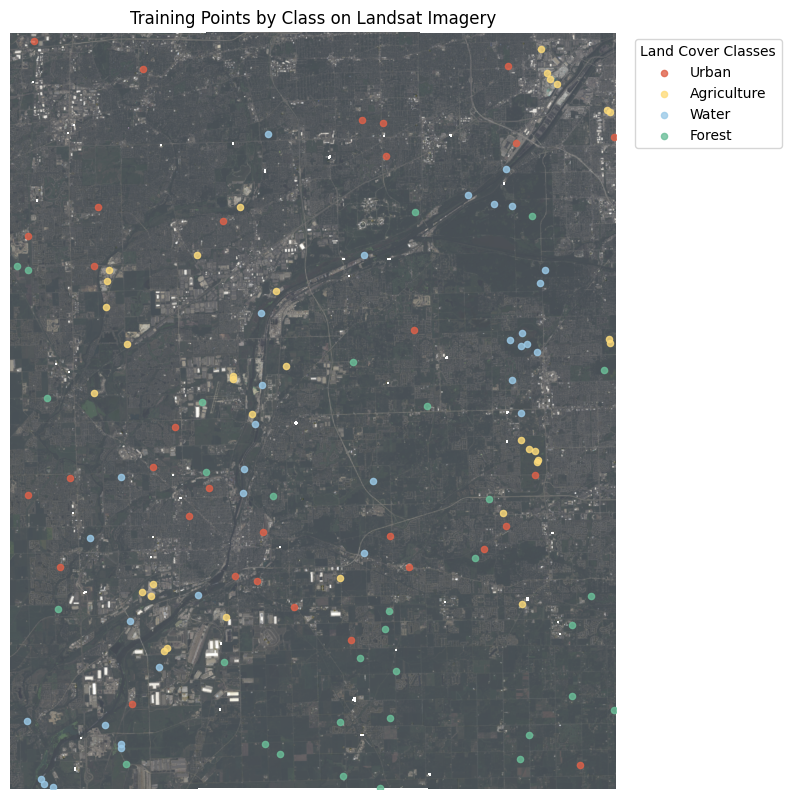

In [64]:
# Select bands for RGB visualization
#
rgb_bands = [3, 2, 1] # index start from 0 so needs to -1
rgb = image[rgb_bands]

# Normalize to 0-1 range (handles any bit-depth)
rgb = rgb.astype('float32')
for i in range(3):
    rgb[i] = (rgb[i] - np.nanmin(rgb[i])) / (np.nanmax(rgb[i]) - np.nanmin(rgb[i])) + 0.1
rgb = np.clip(rgb, 0, 1)  # Ensure valid range
rgb = np.transpose(rgb, (1, 2, 0))  # Convert to [height, width, bands]

# Plot
fig, ax = plt.subplots(figsize=(8, 10))

# Display RGB image
ax.imshow(rgb, extent=[bounds.left, bounds.right, bounds.bottom, bounds.top])

# Define colors for each class
class_colors = {
    0: class4_palette[0],
    1: class4_palette[1],
    2: class4_palette[2],
    3: class4_palette[3]
}

class_category = {
    0: 'Urban',
    1: 'Agriculture',
    2: 'Water',
    3: 'Forest'
}

# Plot each class separately with its color
for class_val, color in class_colors.items():
    class_points = labels[labels['class'] == class_val]
    if not class_points.empty:
        class_points.plot(
            ax=ax,
            marker='o',
            color=color,
            markersize=20,
            alpha=0.8,
            edgecolor=color,
            linewidth=1,
            label=class_category[class_val]
        )

# Add legend
ax.legend(title='Land Cover Classes', bbox_to_anchor=(1.02, 1), loc='upper left')
ax.axis('off')  # Hide axes

plt.title('Training Points by Class on Landsat Imagery')
plt.tight_layout()
plt.show()

## 3. Model Training and Evaluation

### 3.1 Model Training
 Train and evaluate a random forest model using the training set with all engineered features.

After training, analyze [variable importance scores](https://stackoverflow.com/questions/74519767/interpreting-variable-importance-from-random-forest-in-gee) to justify each feature's inclusion. Identify which features are most influential in the classification. Report the final features that you keep in your model.

In [65]:
# Extract coordinates from GeoJSON
point_coords = [(geom.x, geom.y) for geom in labels.geometry]

# Extract pixel values for all bands
with rasterio.open(landsat_path) as src:
    pixel_values = list(src.sample(point_coords))  # Returns a generator
    pixel_values = np.array(pixel_values)  # Convert to array [n_points, n_bands]

# Add extracted values to GeoDataFrame
for band in range(pixel_values.shape[1]):
    labels[f'band_{band+1}'] = pixel_values[:, band]  # +1 for 1-based band numbering

labels.head()

,id,class,geometry,band_1,band_2,band_3,band_4,band_5,band_6,band_7,...,band_23,band_24,band_25,band_26,band_27,band_28,band_29,band_30,band_31,band_32
0,0_2,0,POINT (-9800464.382 5085048.158),0.059160,0.080252,0.144080,0.143750,0.272120,0.297392,0.256115,...,0.051617,0.137637,-0.057172,0.278805,0.266200,-0.001375,0.236995,-0.303683,0.226787,0.231851
1,0_3,0,POINT (-9809179.429 5092575.858),0.041230,0.048490,0.068208,0.061443,0.261230,0.160333,0.097028,...,0.276073,-0.003492,0.065175,0.267904,0.271650,0.119818,0.081978,0.063745,0.170420,0.173865
2,0_4,0,POINT (-9819830.587 5088352.63),0.019230,0.030285,0.050223,0.051323,0.272588,0.170260,0.095927,...,0.036658,0.109752,0.064268,0.287224,0.287591,-0.065670,0.032340,0.073947,0.197945,0.191186
3,0_5,0,POINT (-9816676.896 5118138.619),0.029872,0.033145,0.052752,0.042907,0.301793,0.172405,0.088557,...,-0.026262,-0.223163,0.059648,0.283155,0.308645,0.048923,-0.026372,0.006957,0.174168,0.172721
4,0_6,0,POINT (-9812978.3 5129584.5),0.016508,0.019917,0.040405,0.029350,0.321647,0.151423,0.071617,...,-0.043230,-0.130625,-0.018838,0.279602,0.307254,0.073095,-0.044990,0.032972,0.170794,0.163081


The column name is not helpful for understanding, so now we change the column name to the actual band names.

In [74]:
df_complete_stats_with_index = df_complete_stats.reset_index()
df_complete_stats_with_index['index'] = df_complete_stats_with_index['index'] + 1

band_name_mapping = dict(zip(
    df_complete_stats_with_index['index'],
    df_complete_stats_with_index['band_id']
))

print(band_name_mapping)

{1: 'SR_B1', 2: 'SR_B2', 3: 'SR_B3', 4: 'SR_B4', 5: 'SR_B5', 6: 'SR_B6', 7: 'SR_B7', 8: 'NDVI', 9: 'NDBI', 10: 'MNDWI', 11: 'elevation', 12: 'slope', 13: 'SR_B3_sobel_h', 14: 'SR_B3_sobel_v', 15: 'SR_B3_laplacian', 16: 'SR_B3_mean', 17: 'SR_B3_gauss', 18: 'SR_B4_sobel_h', 19: 'SR_B4_sobel_v', 20: 'SR_B4_laplacian', 21: 'SR_B4_mean', 22: 'SR_B4_gauss', 23: 'SR_B5_sobel_h', 24: 'SR_B5_sobel_v', 25: 'SR_B5_laplacian', 26: 'SR_B5_mean', 27: 'SR_B5_gauss', 28: 'SR_B6_sobel_h', 29: 'SR_B6_sobel_v', 30: 'SR_B6_laplacian', 31: 'SR_B6_mean', 32: 'SR_B6_gauss'}


In [76]:
# Generate new column names
new_columns = []
for col in labels.columns:
    if col.startswith('band_'):
        band_id = int(col.split('_')[1])
        new_name = band_name_mapping.get(band_id, col)  # Fallback to original if not found
        new_columns.append(new_name)
    else:
        new_columns.append(col)  # Keep non-band columns unchanged

# Assign new column names
labels.columns = new_columns

labels.head()

,id,class,geometry,SR_B1,SR_B2,SR_B3,SR_B4,SR_B5,SR_B6,SR_B7,NDVI,NDBI,MNDWI,elevation,slope,SR_B3_sobel_h,SR_B3_sobel_v,SR_B3_laplacian,SR_B3_mean,SR_B3_gauss,SR_B4_sobel_h,SR_B4_sobel_v,SR_B4_laplacian,SR_B4_mean,SR_B4_gauss,SR_B5_sobel_h,SR_B5_sobel_v,SR_B5_laplacian,SR_B5_mean,SR_B5_gauss,SR_B6_sobel_h,SR_B6_sobel_v,SR_B6_laplacian,SR_B6_mean,SR_B6_gauss
0,0_2,0,POINT (-9800464.382 5085048.158),0.059160,0.080252,0.144080,0.143750,0.272120,0.297392,0.256115,0.308678,0.044376,-0.347275,195.0,0.495159,-0.107360,0.174845,-0.167118,0.108848,0.109270,-0.087890,0.154935,-0.146190,0.117443,0.114924,0.051617,0.137637,-0.057172,0.278805,0.266200,-0.001375,0.236995,-0.303683,0.226787,0.231851
1,0_3,0,POINT (-9809179.429 5092575.858),0.041230,0.048490,0.068208,0.061443,0.261230,0.160333,0.097028,0.619165,-0.239342,-0.403102,205.0,1.030274,0.005307,0.047987,0.009845,0.067193,0.070505,-0.012815,0.068420,0.021450,0.064673,0.066900,0.276073,-0.003492,0.065175,0.267904,0.271650,0.119818,0.081978,0.063745,0.170420,0.173865
2,0_4,0,POINT (-9819830.587 5088352.63),0.019230,0.030285,0.050223,0.051323,0.272588,0.170260,0.095927,0.683106,-0.231067,-0.544431,187.0,1.531987,-0.104610,-0.050930,0.048015,0.074863,0.064966,-0.126693,-0.017188,0.060638,0.078422,0.068427,0.036658,0.109752,0.064268,0.287224,0.287591,-0.065670,0.032340,0.073947,0.197945,0.191186
3,0_5,0,POINT (-9816676.896 5118138.619),0.029872,0.033145,0.052752,0.042907,0.301793,0.172405,0.088557,0.751044,-0.272856,-0.531417,208.0,1.018769,0.011220,0.050435,-0.007920,0.054502,0.050566,0.018040,0.072215,0.006160,0.050372,0.043856,-0.026262,-0.223163,0.059648,0.283155,0.308645,0.048923,-0.026372,0.006957,0.174168,0.172721
4,0_6,0,POINT (-9812978.3 5129584.5),0.016508,0.019917,0.040405,0.029350,0.321647,0.151423,0.071617,0.832762,-0.359830,-0.578736,221.0,0.819919,0.032807,-0.011192,0.007370,0.056889,0.045127,0.043450,0.006600,0.012788,0.051251,0.036172,-0.043230,-0.130625,-0.018838,0.279602,0.307254,0.073095,-0.044990,0.032972,0.170794,0.163081


Split the data into a training dataset (70%) and a validation dataset (30%).

In [81]:
# Define your feature set and target
features = labels.columns.tolist()[3:]
X = labels[features]
y = labels["class"]

# 70% training, 30% validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [84]:
# Initialize the model
model1 = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the training set
model1.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Check the importance of our inputs.

In [85]:
importances = model1.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
for i in range(len(features)):
    print(f"{i+1}. {features[indices[i]]} ({importances[indices[i]]:.4f})")

Feature ranking:
1. SR_B5_mean (0.0811)
2. SR_B6_mean (0.0617)
3. SR_B5_gauss (0.0610)
4. SR_B3_gauss (0.0569)
5. SR_B3_mean (0.0476)
6. SR_B6_gauss (0.0470)
7. SR_B7 (0.0467)
8. SR_B5 (0.0438)
9. NDVI (0.0381)
10. NDBI (0.0362)
11. SR_B4_mean (0.0361)
12. SR_B4_gauss (0.0347)
13. SR_B3 (0.0328)
14. MNDWI (0.0322)
15. slope (0.0315)
16. SR_B2 (0.0292)
17. SR_B1 (0.0272)
18. SR_B4 (0.0269)
19. SR_B6 (0.0264)
20. elevation (0.0249)
21. SR_B4_laplacian (0.0191)
22. SR_B3_laplacian (0.0190)
23. SR_B6_sobel_v (0.0189)
24. SR_B4_sobel_v (0.0157)
25. SR_B5_sobel_h (0.0157)
26. SR_B3_sobel_v (0.0156)
27. SR_B6_laplacian (0.0151)
28. SR_B5_sobel_v (0.0142)
29. SR_B6_sobel_h (0.0140)
30. SR_B4_sobel_h (0.0112)
31. SR_B5_laplacian (0.0103)
32. SR_B3_sobel_h (0.0093)


In [93]:
features = ['SR_B5_mean', 'SR_B6_mean', 'SR_B5_gauss', 'SR_B3_gauss']
X = labels[features]
y = labels["class"]

# 70% training, 30% validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the model
model1 = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the training set
model1.fit(X_train, y_train)

importances = model1.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
for i in range(len(features)):
    print(f"{i+1}. {features[indices[i]]} ({importances[indices[i]]:.4f})")

Feature ranking:
1. SR_B6_mean (0.2965)
2. SR_B5_mean (0.2621)
3. SR_B3_gauss (0.2416)
4. SR_B5_gauss (0.1997)


### 3.2 Accuracy Assessment

Use the trained model to classify the Landsat 8 image, creating a land cover classification map with classes for urban, bare, water, and vegetation (or whatever classes you have chosen).

Using the validation data, generate a confusion matrix and calculate the overall accuracy, precision, and recall. Which classes were confused most often with each other? Why do you think this was?

Visually compare your landcover data for your ROI with the corresponding [landcover data from the European Space Agency](https://developers.google.com/earth-engine/datasets/catalog/ESA_WorldCover_v200). Do your classifications agree? If not, do you notice any patterns in the types of landcover where they differ, or any particular features in the imagery that are hard for your model to recognize (e.g., sand, water, or asphalt)?

Export the classified image as a GeoTIFF and the confusion matrix and accuracy metrics to a CSV file for documentation.

## 4. Reflection Questions

What limitations did you run into when completing this assignment? What might you do differently if you repeated it, or what might you change if you had more time and/or resources?

What was the impact of feature engineering? Which layers most contributed to the model? Did you expect this? Why or why not?

Did you find it difficult to create the training data by hand? Did you notice any issues with class imbalance? If so, how might you resolve this in the future (hint: consider a different sampling technique).

Did your model perform better on one class than another? Why? Can you think of a reason that this might be good or bad depending on the context?
